## 1. Introduction

In this notebook we study how linear regression models (OLS, Ridge, Lasso)
can be used to predict node-level attributes from graph-structured data.
We start from a simple graph and gradually build the regression pipeline.

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Make results reproducible (consistent)
rng = np.random.default_rng(seed=42)

## 2. Graph Construction

We will be using GitHub Social Network as our dataset.

In [3]:
csv_name = "git_web_ml/musae_git_edges.csv"

print("Loading Graph from CSV...")
# Load the edge list
df_edges = pd.read_csv(csv_name)
G = nx.from_pandas_edgelist(df_edges, 'id_1', 'id_2')

# Print edge and node counts
print(f"Nodes: {G.number_of_nodes():,}")
print(f"Edges: {G.number_of_edges():,}")

Loading Graph from CSV...
Nodes: 37,700
Edges: 289,003


## 3. Graph Feature Extraction

We compute basic graph-theoretic features for each node.

In [4]:
## 3. Graph Feature Extraction (Optimized for Large Graphs)

print("Extracting features... this may take 10 minutes.")

# 1. Degree
degree_dict = dict(G.degree())

# 2. PageRank
pagerank_dict = nx.pagerank(G, alpha=0.85)

# 3. Clustering Coefficient
clustering_dict = nx.clustering(G)

# 4. Approximate Betweenness
betweenness_dict = nx.betweenness_centrality(G, k=5000, seed=42)

# Construct Feature Matrix X
nodes = list(G.nodes())
X = np.column_stack([
    [degree_dict[n] for n in nodes],
    [pagerank_dict[n] for n in nodes],
    [clustering_dict[n] for n in nodes],
    [betweenness_dict[n] for n in nodes]
])

feature_names = ["degree", "pagerank", "clustering", "betweenness"]

print("X shape:", X.shape)
print("First 5 rows of X:\n", X[:5])

Extracting features... this may take 10 minutes.
X shape: (37700, 4)
First 5 rows of X:
 [[1.00000000e+00 5.34594114e-06 0.00000000e+00 0.00000000e+00]
 [3.20000000e+01 5.24541124e-05 9.87903226e-02 1.59873608e-04]
 [8.00000000e+00 1.66341155e-05 1.78571429e-01 5.39284574e-07]
 [2.00000000e+00 7.01679203e-06 0.00000000e+00 1.81676054e-07]
 [4.00000000e+01 5.19759100e-05 1.76923077e-01 1.62752231e-05]]


## 4. Target Variable Definition

Since we have Degree, Page Rank, Betweeness and Clustering we will need 4 weights for the formula ($y = wX + noise$)

In [5]:
# High Influence Formula = High Degree + High Betweeness
# Weights: [Degree, PageRank, Clustering, Betweenness]
w_true = np.array([0.5, 10.0, -2.0, 15.0])
bias_true = 5.0

# Add noise
noise = rng.normal(0.0, 2.0, size=X.shape[0])

# Target y
y = X @ w_true + bias_true + noise

print("True weights:", w_true)
print("Target Mean:", np.mean(y))
print("Target Std Dev:", np.std(y)) 

True weights: [ 0.5 10.  -2.  15. ]
Target Mean: 12.346414158645924
Target Std Dev: 40.490951875182866


## 5. Train / Test Split

We split the data into training and test sets.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 26390
Test size: 11310


## 6. Regression Models

We train OLS, Ridge (L2) and Lasso (L1) regression models.

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# OLS
ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)

# Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Lasso
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

## 7. Results

We compare the models using RMSE and analyze the learned coefficients.

In [8]:
print("=== RMSE (Test Set) ===")
print("OLS  :", rmse(y_test, y_pred_ols))
print("Ridge:", rmse(y_test, y_pred_ridge))
print("Lasso:", rmse(y_test, y_pred_lasso))

print("\n=== Learned Coefficients ===")
print("Feature names:", feature_names)

print("OLS  :", ols.coef_)
print("Ridge:", ridge.coef_)
print("Lasso:", lasso.coef_)

=== RMSE (Test Set) ===
OLS  : 2.0198362707050923
Ridge: 2.0199122901406064
Lasso: 2.0209378321391203

=== Learned Coefficients ===
Feature names: ['degree', 'pagerank', 'clustering', 'betweenness']
OLS  : [ 4.99296829e-01  5.57377209e+02 -1.98946258e+00  7.84281348e+00]
Ridge: [ 0.50031793  0.03924004 -1.98747341  2.65788086]
Lasso: [ 0.50039885  0.         -1.79009484  0.        ]


## 8. Visualization

We visualize predicted versus true values for the 3 models.

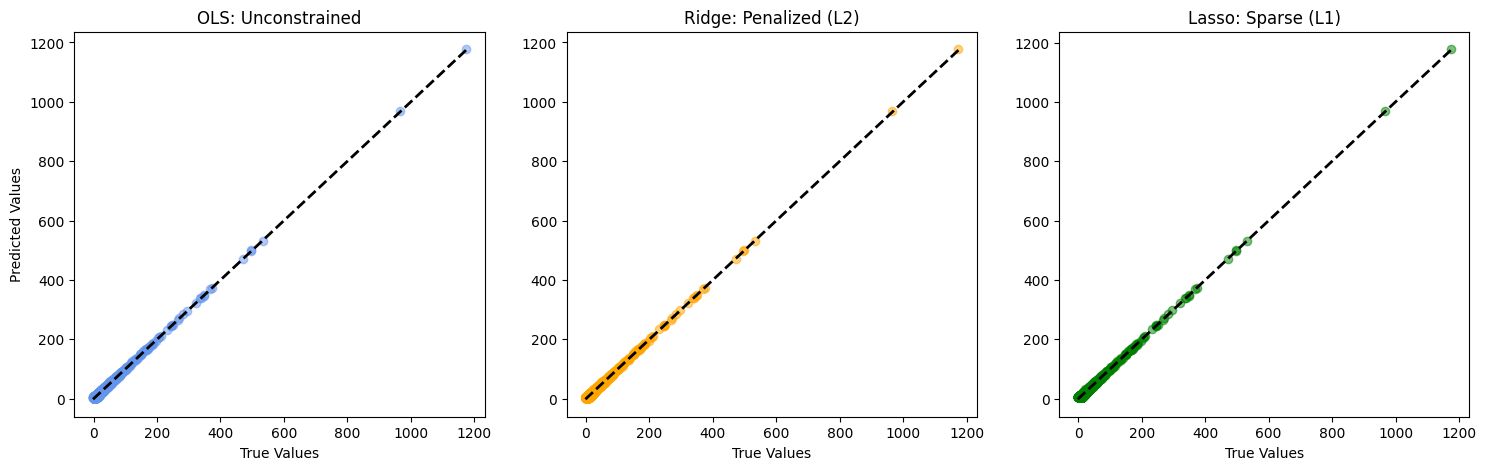

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: OLS
ax1.scatter(y_test, y_pred_ols, alpha=0.5, color='cornflowerblue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
ax1.set_title("OLS: Unconstrained")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predicted Values")

# Plot 2: Ridge
ax2.scatter(y_test, y_pred_ridge, alpha=0.5, color='orange')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax2.set_title("Ridge: Penalized (L2)")
ax2.set_xlabel("True Values")

# Plot 3: Lasso
ax3.scatter(y_test, y_pred_lasso, alpha=0.5, color='green')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax3.set_title("Lasso: Sparse (L1)")
ax3.set_xlabel("True Values")

plt.show()

## 9. Effect of Regularization 

We study how Lasso sparsity changes with the regularization parameter.

In [10]:
alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]

for a in alphas:
    m = Lasso(alpha=a, max_iter=20000)
    m.fit(X_train, y_train)
    zeros = np.sum(np.isclose(m.coef_, 0.0))
    print(f"alpha={a:<4} -> coef={m.coef_}, zeros={zeros}")

alpha=0.001 -> coef=[ 0.50038103  0.         -1.96730324  0.        ], zeros=2
alpha=0.01 -> coef=[ 0.50039885  0.         -1.79009484  0.        ], zeros=2
alpha=0.05 -> coef=[ 0.50047804  0.         -1.00250193  0.        ], zeros=2
alpha=0.1  -> coef=[ 0.50057704  0.         -0.01801073 -0.        ], zeros=2
alpha=0.5  -> coef=[ 0.50053095  0.         -0.          0.        ], zeros=3
alpha=1.0  -> coef=[ 0.50047093  0.         -0.          0.        ], zeros=3


## 10. Feature Importance Bar Chart

Compare learned coefficients of the three models

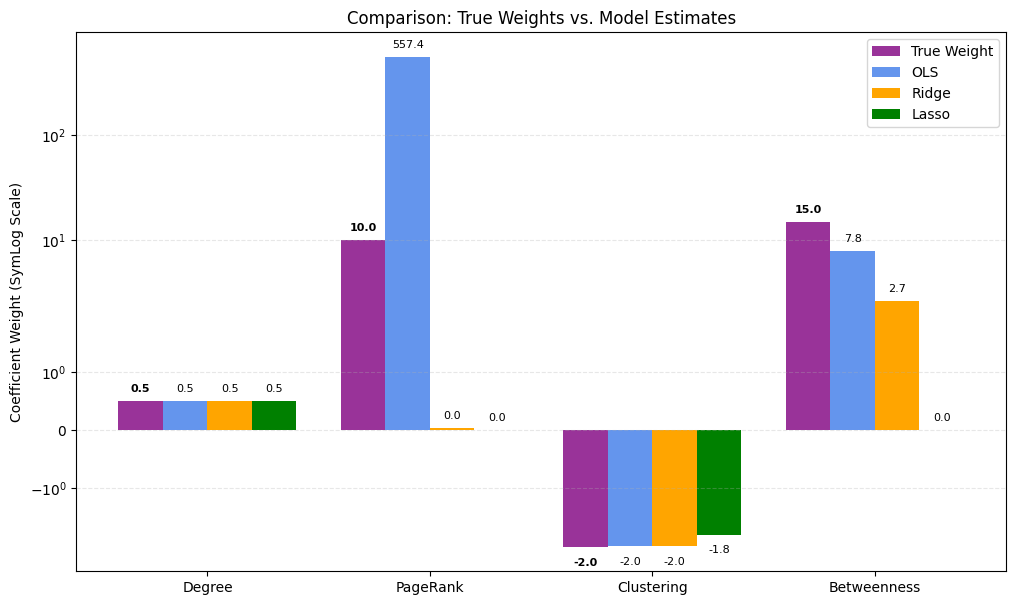

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Data
feature_names = ['Degree', 'PageRank', 'Clustering', 'Betweenness']
x = np.arange(len(feature_names))  # Label locations
width = 0.2  # Width of the bars

# 2. Create Plot
fig, ax = plt.subplots(figsize=(12, 7))

# --- Plot Bars Side-by-Side ---
# Shift positions so they fit 4 bars comfortably
# 1. True Weight (Far Left)
rects_true = ax.bar(x - 1.5 * width, w_true, width, label='True Weight', color='purple', alpha=0.8)

# 2. OLS (Middle Left)
rects1 = ax.bar(x - 0.5 * width, ols.coef_, width, label='OLS', color='cornflowerblue')

# 3. Ridge (Middle Right)
rects2 = ax.bar(x + 0.5 * width, ridge.coef_, width, label='Ridge', color='orange')

# 4. Lasso (Far Right)
rects3 = ax.bar(x + 1.5 * width, lasso.coef_, width, label='Lasso', color='green')

# 3. Formatting
ax.set_ylabel('Coefficient Weight (SymLog Scale)')
ax.set_title('Comparison: True Weights vs. Model Estimates')
ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.legend(loc='upper right')

# Use SymLog scale because OLS is massive
ax.set_yscale('symlog') 
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.margins(y=0.05)

# 4. Annotation Helper
def autolabel(rects, is_true=False):
    for rect in rects:
        height = rect.get_height()
        xy_pos = (rect.get_x() + rect.get_width() / 2, height)
        
        # Make "True" labels bold so they stand out
        font_weight = 'bold' if is_true else 'normal'
        
        ax.annotate(f'{height:.1f}',
                    xy=xy_pos,
                    xytext=(0, 5 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', 
                    fontsize=8, weight=font_weight, rotation=0)

# Apply labels
autolabel(rects_true, is_true=True)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

## 11. Alpha Path Analysis 

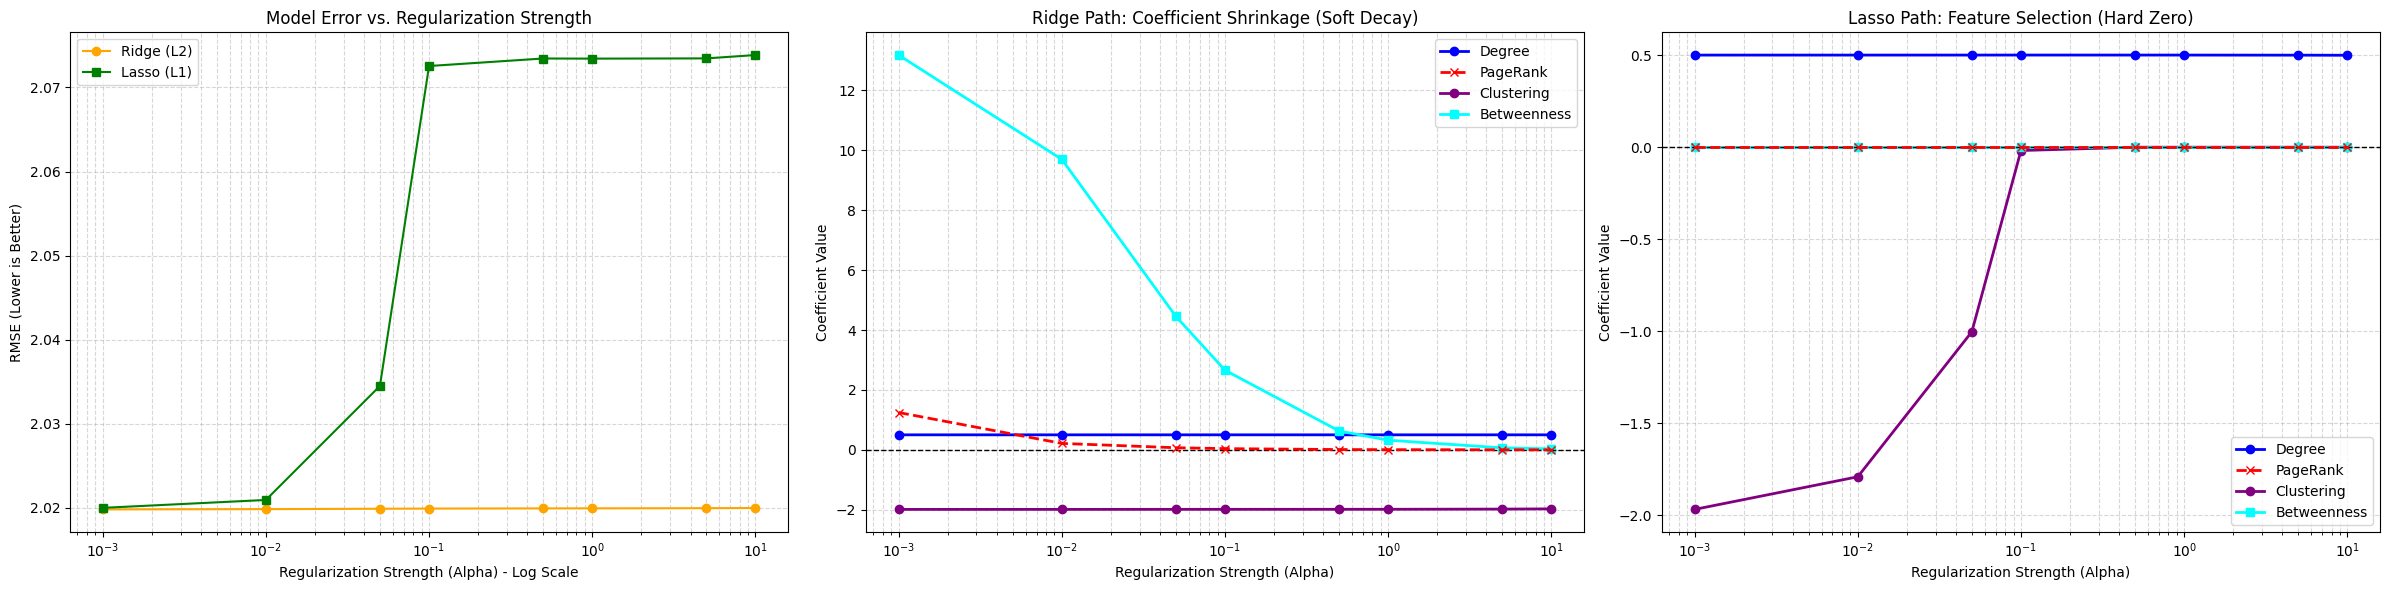

In [13]:
# 1. Setup the Experiment
alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

# Storage for results
lasso_rmse = []
ridge_rmse = []
lasso_coefs = []
ridge_coefs = []

for a in alphas:
    # Train Ridge
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    pred_r = ridge.predict(X_test)
    ridge_rmse.append(np.sqrt(mean_squared_error(y_test, pred_r)))
    ridge_coefs.append(ridge.coef_) # <--- Capture Ridge Coefs
    
    # Train Lasso
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    pred_l = lasso.predict(X_test)
    lasso_rmse.append(np.sqrt(mean_squared_error(y_test, pred_l)))
    lasso_coefs.append(lasso.coef_)

# Convert to matrix for easy plotting
lasso_coefs = np.array(lasso_coefs)
ridge_coefs = np.array(ridge_coefs)

# 3. Visualization
# Increased figsize width (from 16 to 24) to accommodate the 3rd plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# --- Plot 1: Error Analysis (RMSE vs Alpha) ---
ax1.plot(alphas, ridge_rmse, 'o-', label='Ridge (L2)', color='orange')
ax1.plot(alphas, lasso_rmse, 's-', label='Lasso (L1)', color='green')
ax1.set_xscale('log') 
ax1.set_xlabel('Regularization Strength (Alpha) - Log Scale')
ax1.set_ylabel('RMSE (Lower is Better)')
ax1.set_title('Model Error vs. Regularization Strength')
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend()

# Shared Styling for Paths
feature_names = ['Degree', 'PageRank', 'Clustering', 'Betweenness']
colors = ['blue', 'red', 'purple', 'cyan']
markers = ['o', 'x', 'o', 's']       
linestyles = ['-', '--', '-', '-']    

# --- Plot 3: The "Ridge Path" (Feature Shrinkage) ---
for i in range(len(feature_names)):
    z_order = 10 if feature_names[i] == 'PageRank' else 2
    ax2.plot(alphas, ridge_coefs[:, i], 
            marker=markers[i], 
            label=feature_names[i], 
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=2,
            zorder=z_order)

ax2.set_xscale('log')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Regularization Strength (Alpha)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Ridge Path: Coefficient Shrinkage (Soft Decay)')
ax2.grid(True, which="both", ls="--", alpha=0.5)
ax2.legend()

# --- Plot 3: The "Lasso Path" (Feature Death) ---
for i in range(len(feature_names)):
    z_order = 10 if feature_names[i] == 'PageRank' else 2
    ax3.plot(alphas, lasso_coefs[:, i], 
            marker=markers[i], 
            label=feature_names[i], 
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=2,
            zorder=z_order)

ax3.set_xscale('log')
ax3.axhline(0, color='black', linewidth=1, linestyle='--')
ax3.set_xlabel('Regularization Strength (Alpha)')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Lasso Path: Feature Selection (Hard Zero)')
ax3.grid(True, which="both", ls="--", alpha=0.5)
ax3.legend()

plt.tight_layout()
plt.show()